In [1]:
import jax
from jax import numpy as jnp
from multi_object_datasets_torch import MultiDSprites
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
def preprocess(images):
    batch_size, num_channels, width, height = images.shape

    x_coords = jnp.linspace(-1, 1, num=width)
    y_coords = jnp.linspace(-1, 1, num=height)
    x_grid, y_grid = jnp.meshgrid(x_coords, y_coords, indexing="ij")

    x_grid = x_grid[None, None, :, :].repeat(batch_size, axis=0)
    y_grid = y_grid[None, None, :, :].repeat(batch_size, axis=0)

    return jnp.concatenate([images, x_grid, y_grid], axis=1)

    # images_with_pos = jnp.concatenate([images, x_grid, y_grid], axis=1)

    # data_flat = images_with_pos.reshape(batch_size, -1)
    # mean = jnp.mean(data_flat, axis=1, keepdims=True)
    # std = jnp.std(data_flat, axis=1, keepdims=True) + 1e-8
    # data_flat_normalized = (data_flat - mean) / std

    # return data_flat_normalized.reshape(images_with_pos.shape)

In [3]:
def log_likelihood(inputs, mu):
    sq_diff = (inputs[:, :, None, :] - mu[:, None, :, :]) ** 2
    dist_sq = jnp.sum(sq_diff, axis=-1)
    return -0.5 * dist_sq


def fit_gmm(inputs, K, key, num_iter=100, epsilon=1e-8):
    B, N, D = inputs.shape
    mu = jax.random.uniform(key, (B, K, D), minval=-1, maxval=1)
    pi = jnp.ones((B, K)) / K

    for _ in range(num_iter):
        log_lik = log_likelihood(inputs, mu)
        logits = log_lik + jnp.log(pi + epsilon)[:, None, :]
        gamma = jax.nn.softmax(logits, axis=-1)

        pi = jnp.mean(gamma, axis=1)
        gamma_sum = jnp.sum(gamma, axis=1, keepdims=True) + epsilon
        mu = jnp.einsum("bnk,bnd->bkd", gamma, inputs) / gamma_sum.transpose(0, 2, 1)
     
    return mu, pi, gamma

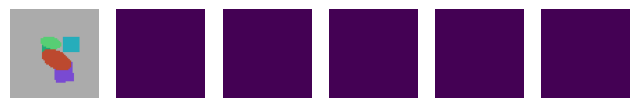

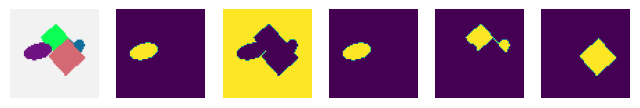

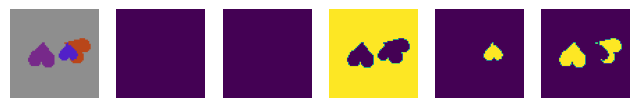

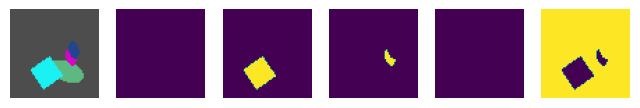

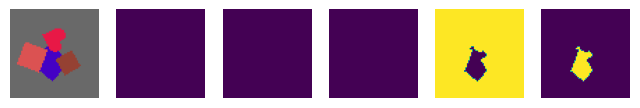

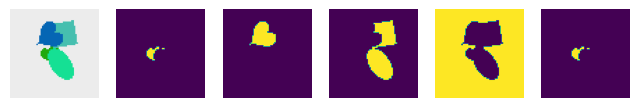

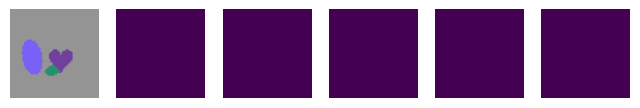

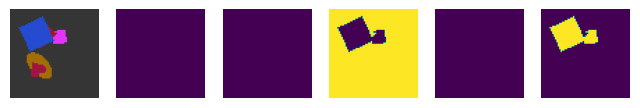

In [4]:
key = jax.random.PRNGKey(0)
K, num_samples = 5, 8
training_data = MultiDSprites("./data/datasets")
train_dataloader = DataLoader(training_data, batch_size=num_samples)
data = next(iter(train_dataloader))

images = data["image"]
images = jnp.array(images)
images = preprocess(images)

B, D, W, H = images.shape
N = W * H
images = images.reshape(B, D, N).transpose(0, 2, 1)

mu, pi, gamma = fit_gmm(images, K, key)

gamma_reshaped = gamma.reshape(B, W, H, K)
for sample_idx in range(B):
    fig, axs = plt.subplots(1, K + 1, figsize=(8, 5))
    axs[0].imshow(data["image"][sample_idx, :].permute(1, 2, 0))
    axs[0].axis("off")

    for k in range(K):
        axs[k + 1].imshow(gamma_reshaped[sample_idx, :, :, k])
        axs[k + 1].axis("off")
    plt.show()